In [1]:
import sympy as sy
time, x, xdot, delta = sy.symbols('t x_1 x_2 \\delta')

from sympy import latex
from IPython.display import display_latex

def disp(idx, symObj):
    eqn = '\\[' + idx + ' ' + latex(symObj) + '\\]'
    display_latex(eqn,raw=True)
    return

from IPython.display import display_latex
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize, least_squares

import ssmlearnpy.reduced_dynamics.normalform as normalform
from ssmlearnpy.utils import ridge
from ssmlearnpy.reduced_dynamics.shift_or_differentiate import shift_or_differentiate
from scipy.io import savemat, loadmat

import logging
logger = logging.getLogger("ridge_regression")
logger.setLevel(logging.WARNING)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize, least_squares

import ssmlearnpy.reduced_dynamics.normalform as normalform
from ssmlearnpy.utils import ridge
from ssmlearnpy.reduced_dynamics.shift_or_differentiate import shift_or_differentiate
from scipy.io import savemat, loadmat

import logging
logger = logging.getLogger("ridge_regression")
logger.setLevel(logging.WARNING)

We consider the following nonlinear ODE

$$
\ddot{x} = -x - \delta (x^2 - 1) \dot{x},
$$

In first order form, the vector field reads

In [2]:
RHS = sy.Matrix([xdot, -x - delta*xdot*x**2 + delta*xdot])
disp('\\frac{d}{dt}\\begin{pmatrix}x_1 \\\ x_2 \\end{pmatrix}=',RHS)

Its Jacobian at the fixed point is

In [3]:
J = RHS.jacobian([x, xdot]).subs([(x, 0), (xdot, 0)])
disp('J=', J)

which has eigenvalues

In [4]:
eigenvals = J.eigenvals(multiple = True)
for e in eigenvals:
    disp('\\lambda = ', e)

In [143]:
deltaa = 2.68

For damping $\delta = 0.1$, we have

$$
\lambda = 0.05\pm0.998749218𝑖
$$

### Create data

In [144]:
def vectorfield(t,x):
    return np.array([x[1],-x[0] - deltaa*x[1]*(x[0]**2 - 1.0)])

In [145]:
t = np.linspace(0, 100, 1001)
dt = t[1] - t[0]

In [146]:
# Initial conditions
ic_0 = np.array([-2.0, 1.0])
ic_1 = np.array([2.0, .321])

In [147]:
# Numerical solutions
sol_0 = solve_ivp(vectorfield, [t[0], t[-1]], ic_0, t_eval=t)
sol_1 = solve_ivp(vectorfield, [t[0], t[-1]], ic_1, t_eval=t)

In [148]:
# Reshape solutions into array "trajectories"
trajectories = [sol_0.y - np.array([1,0]).reshape(-1,1), sol_1.y - np.array([1,0]).reshape(-1,1)]
# Array containing time spawn
times = [t, t]

### Plot data

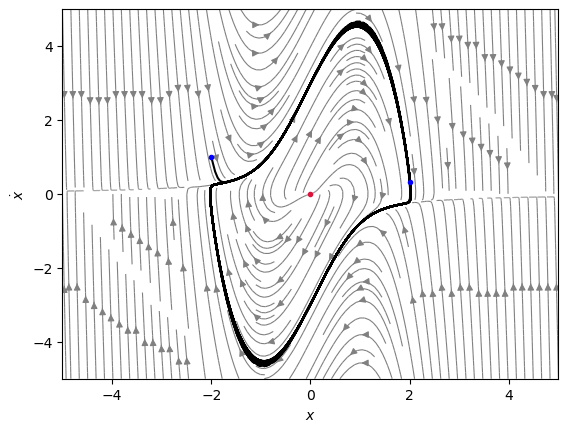

In [149]:
xx = np.linspace(-5, 5, 30)
yy = np.linspace(-5, 5, 30)
Xmesh, Ymesh = np.meshgrid(xx, yy)
grid = np.vstack((Xmesh.ravel(), Ymesh.ravel()))
U, V = vectorfield(0, grid)
U = U.reshape(Xmesh.shape)
V = V.reshape(Xmesh.shape)

plt.streamplot(Xmesh, Ymesh, U, V, color='grey', linewidth = 0.8, density = 2)
plt.xlabel('$x$')
plt.ylabel('$\\dot{x}$')

for t in trajectories:
    plt.plot(t[0,:]+1, t[1,:], '-', c='black')
plt.plot(0,0, '.', c='crimson')
plt.plot(ic_0[0],ic_0[1], '.', c='blue')
plt.plot(ic_1[0],ic_1[1], '.', c='blue')

### Fit using SSMLearn

In [150]:
# Order
polyDeg = 3
# Degrees of freedom
ndofs = 1

In [151]:
X, y  = shift_or_differentiate(trajectories, times, 'flow') 

In [152]:
# The _ array contains the trajectories
X == trajectories

True

In [153]:
# The y array contains d./dt of the trajectories
y

[array([[ 0.97690093,  0.59712334,  0.43644812, ..., -2.59158986,
         -3.37839934, -4.28265818],
        [-5.76462257, -2.36039717, -1.04039865, ..., -7.01123544,
         -8.76917389, -8.22362994]]),
 array([[ 3.08010742e-01, -2.00007578e-03, -1.37271433e-01, ...,
          5.88389228e-01,  6.45616620e-01,  7.16663588e-01],
        [-4.50773464e+00, -2.00072818e+00, -8.95675576e-01, ...,
          5.10518862e-01,  6.33183433e-01,  7.96214362e-01]])]

In [154]:
# A priori knowledge
# Add the constraints to the fixed points explicitly
constLHS = [[0, 0]]
constRHS = [[0, 0]]
cons = [constLHS, constRHS]
# Such that model.prediction(LHS) = RHS

In [155]:
# Fit a ridge regression model to the data
# mdl = ridge.get_fit_ridge(X, y, poly_degree = polyDeg, constraints = cons)
mdl = ridge.get_fit_ridge(X, y, poly_degree = polyDeg)

In [156]:
# Check that the constraints are enforced
print(mdl.predict(constLHS), constRHS)

[[0. 0.]] [[0, 0]]


In [157]:
# Get an estimate of the linear part
linearPart = mdl.map_info['coefficients'][:,:2]

In [158]:
"""Minimize
    ||d\dt (y + f_normalform(y)) - \Lambda*(y+f_normalform(y)) - N_normalform(y+f_normalform)||^2
    where \Lambda is the linear part of the dynamics and N_normalform is the nonlinear part of the normal form dynamics
    f_normalform is the nonlinear part of the normal form transformation z = T^{-1}(y) = y + f_normalform(y).
    """
nf, n_unknowns_dynamics, n_unknowns_transformation, objectiv \
    = normalform.create_normalform_transform_objective(times, trajectories, linearPart, degree = polyDeg)

In [159]:
"""We do a ridge regression on the diagonalized coordinates (modal coordinates). 
    The initial condition for the optimization is taken as the modal dynamics ridge regression problem. 
    """
initial_guess = normalform.create_normalform_initial_guess(mdl, nf)

In [160]:
# Solve the objective function with the initial guess
np.random.seed(3)
res = least_squares(objectiv, initial_guess, jac='2-point', method='lm')

In [161]:
# Unpack the optimized coefficients into a dictionary
d = normalform.unpack_optimized_coeffs(res.x, ndofs, nf, n_unknowns_dynamics, n_unknowns_transformation)

Linear part for $\delta = 0.1$,

$$
\lambda = −0.05\pm1.41332940251026𝑖
$$

In [162]:
# Estimated linear part
print(nf.LinearPart[1,1])

(0.2795682174764669-1.1286297345356713j)


In [163]:
# Wrap the optimized coefficients into a NonlinearCoordinateTransform object
trf, dyn = normalform.wrap_optimized_coefficients(ndofs, nf, polyDeg, d )

In [164]:
dyn

{'coefficients': array([[  0.27956822 +1.12862973j,   0.         +0.j        ,
           4.24087    -6.52573852j,   3.10569457 -2.23396082j,
           0.         +0.j        ,  15.85046945+13.85590821j,
         -12.89561374 +4.81953893j, -12.63056931 -2.73072831j,
           0.         +0.j        ]]),
 'exponents': array([[1, 0, 2, 1, 0, 3, 2, 1, 0],
        [0, 1, 0, 1, 2, 0, 1, 2, 3]]),
 'vectorfield': <function ssmlearnpy.reduced_dynamics.normalform.wrap_optimized_coefficients.<locals>.vectorfield(t, x)>}

In [165]:
trajectories[0].shape

(2, 1001)

Text(0.5, 1.0, 'Exact trajectories')

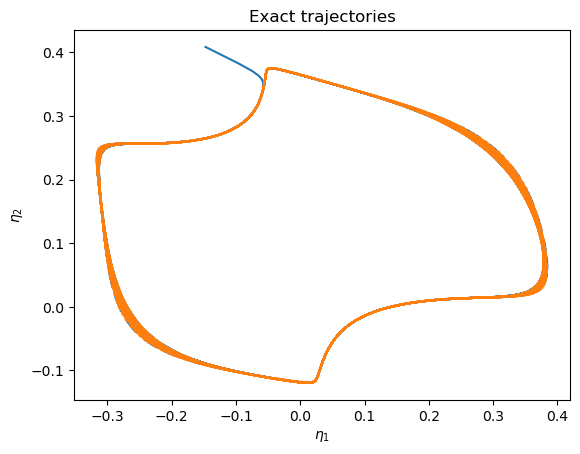

In [166]:
# Plot the trajectories in the normal form coordinates
for t in trajectories:
    transformed = trf.inverse_transform(t) 
    plt.plot(np.real(transformed[0,:]), np.imag(transformed[0,:]))
plt.xlabel('$\\eta_1$')
plt.ylabel('$\\eta_2$')
plt.title('Exact trajectories')

In [167]:
time_pred = np.linspace(0, 100, 1001)

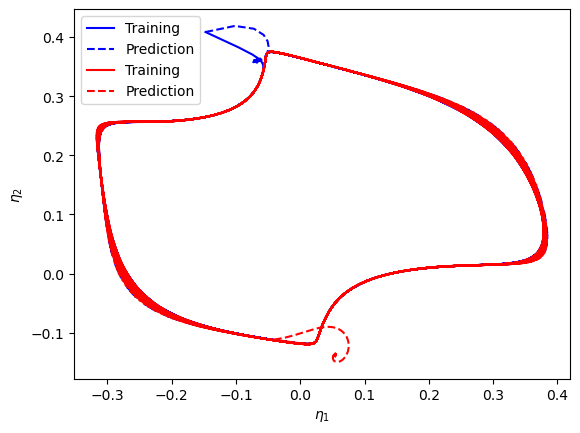

In [168]:
clit=1
for t in trajectories:
    if clit==1:
        transformed = trf.inverse_transform(t)
        plt.plot(np.real(transformed[0,:]), np.imag(transformed[0,:]), '-', c='blue', label = 'Training')
        ic = transformed[:,0]
    
        pred = solve_ivp(dyn['vectorfield'], [time_pred[0], time_pred[-1]], ic, t_eval=time_pred, method = 'DOP853')
        plt.plot(np.real(pred.y[0,:]), np.imag(pred.y[0,:]), '--', c='blue', label = 'Prediction')
        clit+=1
    elif clit==2:
        transformed = trf.inverse_transform(t)
        plt.plot(np.real(transformed[0,:]), np.imag(transformed[0,:]), '-', c='red', label = 'Training')
        ic = transformed[:,0]
    
        pred = solve_ivp(dyn['vectorfield'], [time_pred[0], time_pred[-1]], ic, t_eval=time_pred, method = 'DOP853')
        plt.plot(np.real(pred.y[0,:]), np.imag(pred.y[0,:]), '--', c='red', label = 'Prediction')
        clit+=1
plt.xlabel('$\\eta_1$')
plt.ylabel('$\\eta_2$')
plt.legend()

Compare the results with order = 3, 5, 7, 9

Order: 3, Residual: 22.803700785713602 

Order: 5, Residual: 0.7344631789711645 



/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: overflow encountered in square
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: invalid value encountered in multiply
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: overflow encountered in multiply
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: overflow encountered in power
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: invalid value encountered in power
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:118: RuntimeWarning: invalid value encountered in matmul
  return lambda x : np.matmul(coefficients,
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: overflow encountered in power
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: invalid va

Order: 7, Residual: 0.16959136290179952 



/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: overflow encountered in power
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: invalid value encountered in power
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: invalid value encountered in multiply
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: overflow encountered in multiply
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:118: RuntimeWarning: invalid value encountered in matmul
  return lambda x : np.matmul(coefficients,
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: overflow encountered in power
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: invalid value encountered in power
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: invali

/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: overflow encountered in square
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: invalid value encountered in multiply
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: overflow encountered in multiply
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: overflow encountered in power
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: invalid value encountered in power
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:118: RuntimeWarning: invalid value encountered in matmul
  return lambda x : np.matmul(coefficients,
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:118: RuntimeWarning: overflow encountered in matmul
  return lambda x : np.matmul(coefficients,
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:118:

/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: overflow encountered in power
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: invalid value encountered in power
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: overflow encountered in multiply
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: invalid value encountered in multiply
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:118: RuntimeWarning: invalid value encountered in matmul
  return lambda x : np.matmul(coefficients,
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: overflow encountered in power
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: invalid value encountered in power
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: overfl

/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: overflow encountered in square
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: invalid value encountered in multiply
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: overflow encountered in multiply
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: overflow encountered in power
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:67: RuntimeWarning: invalid value encountered in power
  prod *= y[:,i]**p
/home/tf/SSMLearnPy/ssmlearnpy/utils/preprocessing.py:118: RuntimeWarning: invalid value encountered in matmul
  return lambda x : np.matmul(coefficients,
/usr/lib/python3/dist-packages/scipy/integrate/_ivp/rk.py:507: RuntimeWarning: invalid value encountered in divide
  err5 = np.dot(K.T, self.E5) / scale
/usr/lib/python3/dist-packages/scipy/integrate/_ivp/rk.

ValueError: The normal form is not applicable. All eigenvalues need to be complex

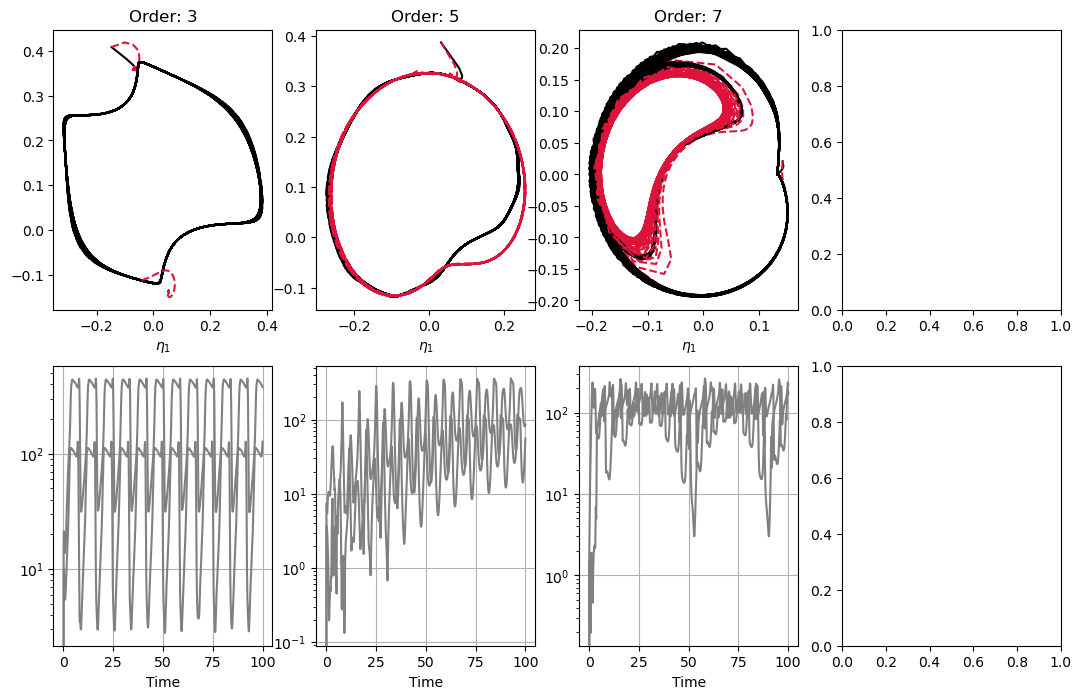

In [169]:
f,ax = plt.subplots(2,4,figsize = (13, 8))
orders = [3, 5, 7, 9]
n_orders = len(orders)
for i in range(n_orders):
    order = orders[i]
    mdl = ridge.get_fit_ridge(X, y, poly_degree = order, constraints = cons) # pre-fit with regular ridge regression
    linearPart = mdl.map_info['coefficients'][:,:2]

    nf, n_unknowns_dynamics, n_unknowns_transformation, objectiv = normalform.create_normalform_transform_objective(times, trajectories, linearPart, degree = order)
    initial_guess = normalform.create_normalform_initial_guess(mdl, nf)
    res = least_squares(objectiv, initial_guess, jac='2-point', method='lm')
    print('Order: %s, Residual: %s \n' %(order, res.cost))
    d = normalform.unpack_optimized_coeffs(res.x, ndofs, nf, n_unknowns_dynamics, n_unknowns_transformation)
    trf, dyn = normalform.wrap_optimized_coefficients(ndofs, nf, order, d )
    ax[0,i].set_xlabel('$\\eta_1$')
    ax[0,i].set_title('Order: %s' %order)
    for t in trajectories:
        transformed = trf.inverse_transform(t)
        ax[0,i].plot(np.real(transformed[0,:]), np.imag(transformed[0,:]), '-', c='black', label = 'Training')
        ic = transformed[:,0]
        pred = solve_ivp(dyn['vectorfield'], [time_pred[0], time_pred[-1]], ic, t_eval=time_pred, method = 'DOP853')
        ax[0,i].plot(np.real(pred.y[0,:]), np.imag(pred.y[0,:]), '--', c='Crimson', label = 'Prediction')
        ## we also compute the error along trajectories
        tonorm = np.max(np.abs(transformed[:,0]))
        error = np.abs(pred.y[0,:] - transformed[0,:])/tonorm
        ax[1,i].semilogy(pred.t, error*100, '-', c='grey', label ='Relative error')
            
    ax[1,i].grid()  
    ax[1,i].set_xlabel('Time')
ax[0,0].set_ylabel('$\\eta_2$')
ax[1,0].set_ylabel('Relative error [%]')

### Predict different trajectories than the ones you trained with

In [ ]:
ic_2 = np.array([1.0, 0.5])
ic_3 = np.array([1.4, 0.])
t = np.linspace(0, 100, 1001)
sol_2 = solve_ivp(vectorfield, [t[0], t[-1]], ic_2, t_eval=t)
sol_3 = solve_ivp(vectorfield, [t[0], t[-1]], ic_3, t_eval=t)
trajectories_new = [sol_2.y - np.array([1,0]).reshape(-1,1), sol_3.y - np.array([1,0]).reshape(-1,1)]

xx = np.linspace(-1.5, 1.5, 30)
yy = np.linspace(-1.5, 1.5, 30)
Xmesh, Ymesh = np.meshgrid(xx, yy)
grid = np.vstack((Xmesh.ravel(), Ymesh.ravel()))
U, V = vectorfield(0, grid)
U = U.reshape(Xmesh.shape)
V = V.reshape(Xmesh.shape)

plt.streamplot(Xmesh, Ymesh, U, V, color='grey', linewidth = 0.8, density = 2)
plt.xlabel('$x$')
plt.ylabel('$\\dot{x}$')

for t in trajectories_new:
    plt.plot(t[0,:]+1, t[1,:], '-', c='black')
plt.plot(0,0, '.', c='crimson')
plt.plot(1,0, '.', c='blue')
plt.plot(-1,0, '.', c='blue')

In [ ]:
# Plot the trajectories in the normal form coordinates
for t in trajectories_new:
    transformed = trf.inverse_transform(t) 
    plt.plot(np.real(transformed[0,:]), np.imag(transformed[0,:]))
plt.xlabel('$\\eta_1$')
plt.ylabel('$\\eta_2$')
plt.title('Exact trajectories')

In [ ]:
f,ax = plt.subplots(2,4,figsize = (13, 8))
orders = [3, 5, 7, 9]
n_orders = len(orders)
for i in range(n_orders):
    order = orders[i]
    mdl = ridge.get_fit_ridge(X, y, poly_degree = order, constraints = cons) # pre-fit with regular ridge regression
    linearPart = mdl.map_info['coefficients'][:,:2]

    nf, n_unknowns_dynamics, n_unknowns_transformation, objectiv = normalform.create_normalform_transform_objective(times, trajectories, linearPart, degree = order)
    initial_guess = normalform.create_normalform_initial_guess(mdl, nf)
    res = least_squares(objectiv, initial_guess, jac='2-point', method='lm')
    print('Order: %s, Residual: %s \n' %(order, res.cost))
    d = normalform.unpack_optimized_coeffs(res.x, ndofs, nf, n_unknowns_dynamics, n_unknowns_transformation)
    trf, dyn = normalform.wrap_optimized_coefficients(ndofs, nf, order, d )
    ax[0,i].set_xlabel('$\\eta_1$')
    ax[0,i].set_title('Order: %s' %order)
    for t in trajectories_new:
        transformed = trf.inverse_transform(t)
        ax[0,i].plot(np.real(transformed[0,:]), np.imag(transformed[0,:]), '-', c='black', label = 'Training')
        ic = transformed[:,0]
        pred = solve_ivp(dyn['vectorfield'], [time_pred[0], time_pred[-1]], ic, t_eval=time_pred, method = 'DOP853')
        ax[0,i].plot(np.real(pred.y[0,:]), np.imag(pred.y[0,:]), '--', c='Crimson', label = 'Prediction')
        ## we also compute the error along trajectories
        tonorm = np.max(np.abs(transformed[:,0]))
        error = np.abs(pred.y[0,:] - transformed[0,:])/tonorm
        ax[1,i].semilogy(pred.t, error*100, '-', c='grey', label ='Relative error')
            
    ax[1,i].grid()  
    ax[1,i].set_xlabel('Time')
ax[0,0].set_ylabel('$\\eta_2$')
ax[1,0].set_ylabel('Relative error [%]')

## Test on real data

In [ ]:
from numpy import loadtxt

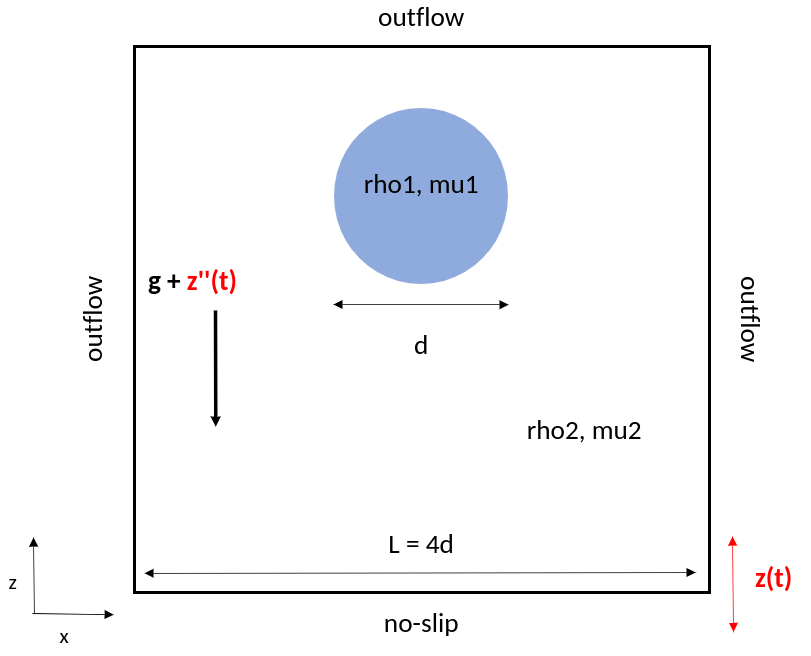

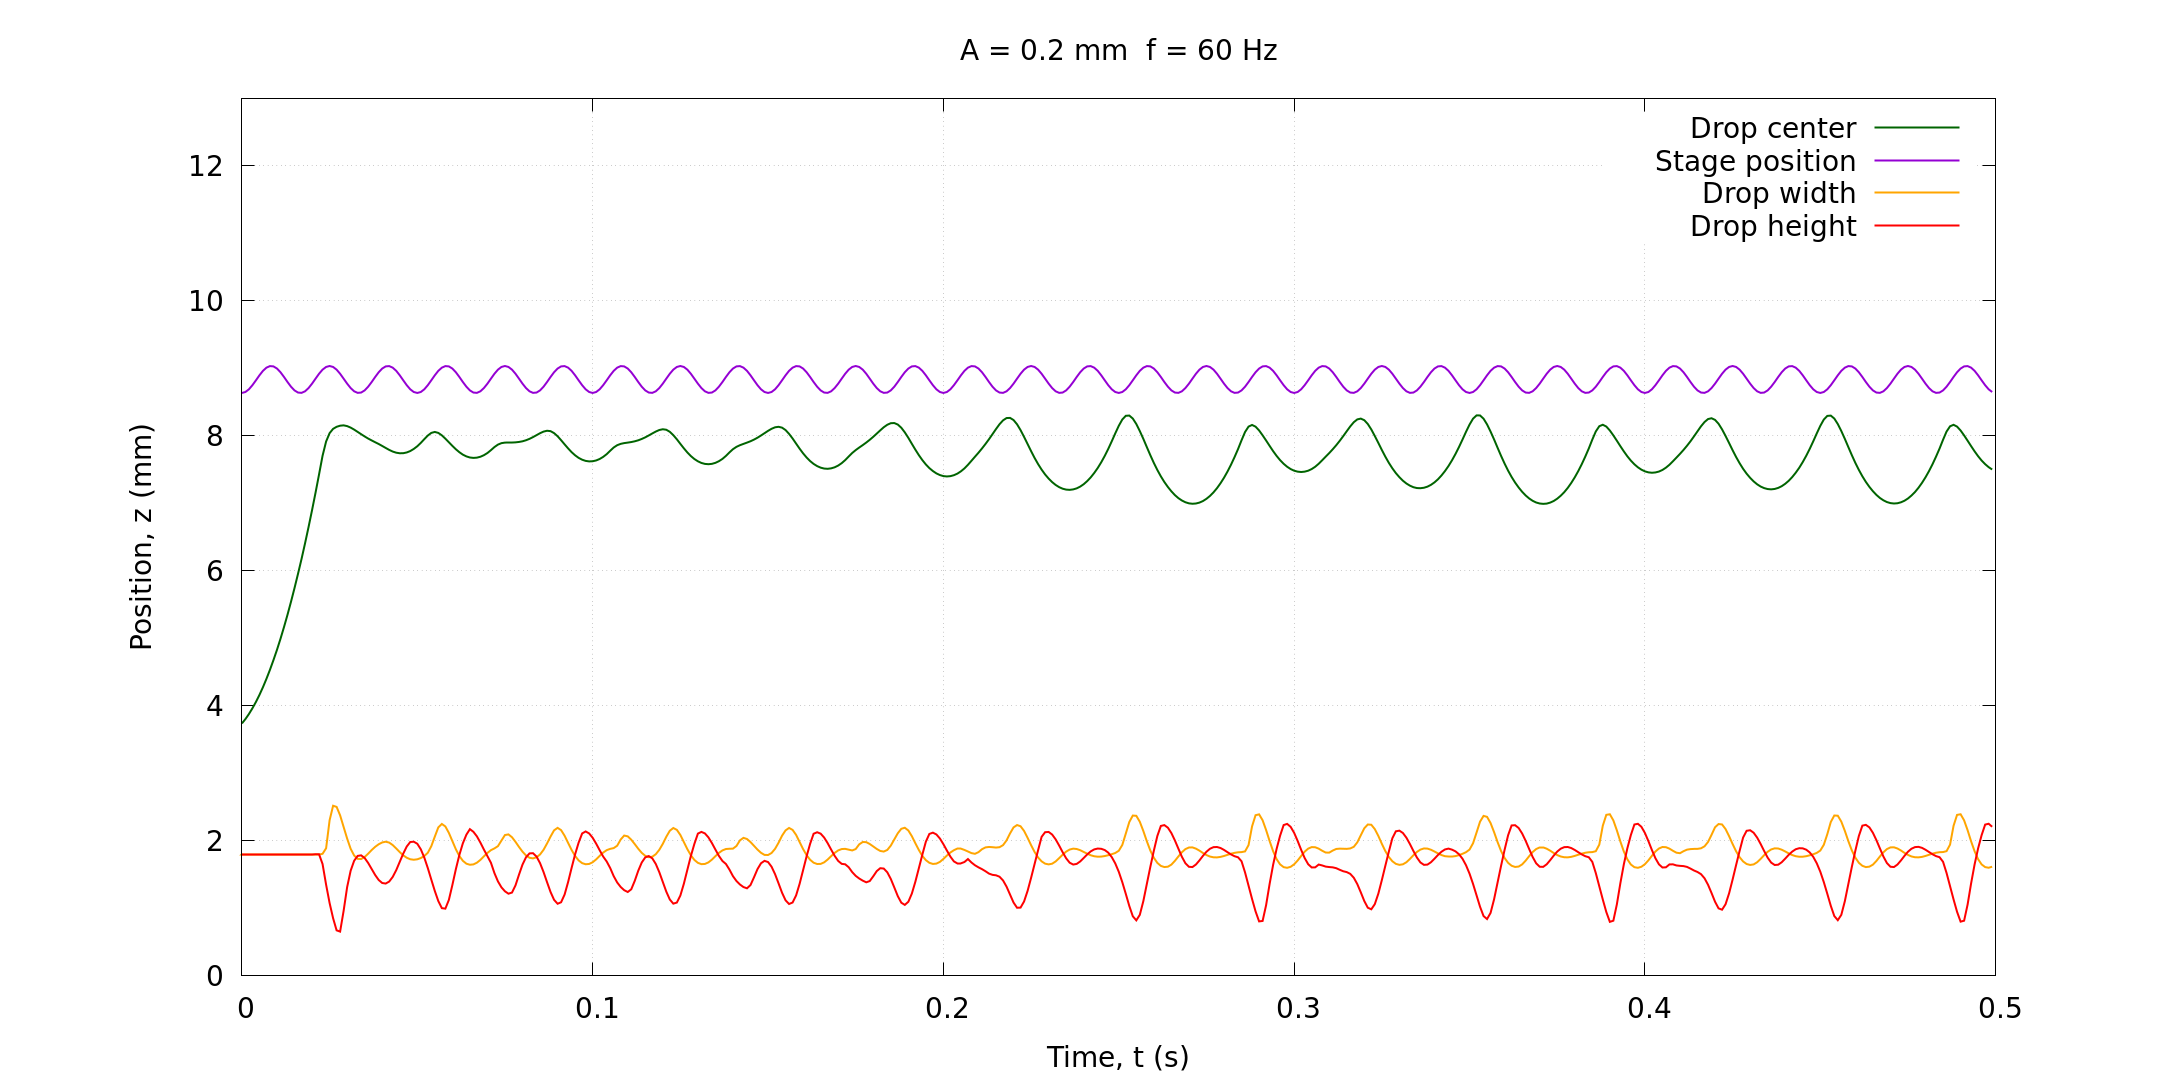

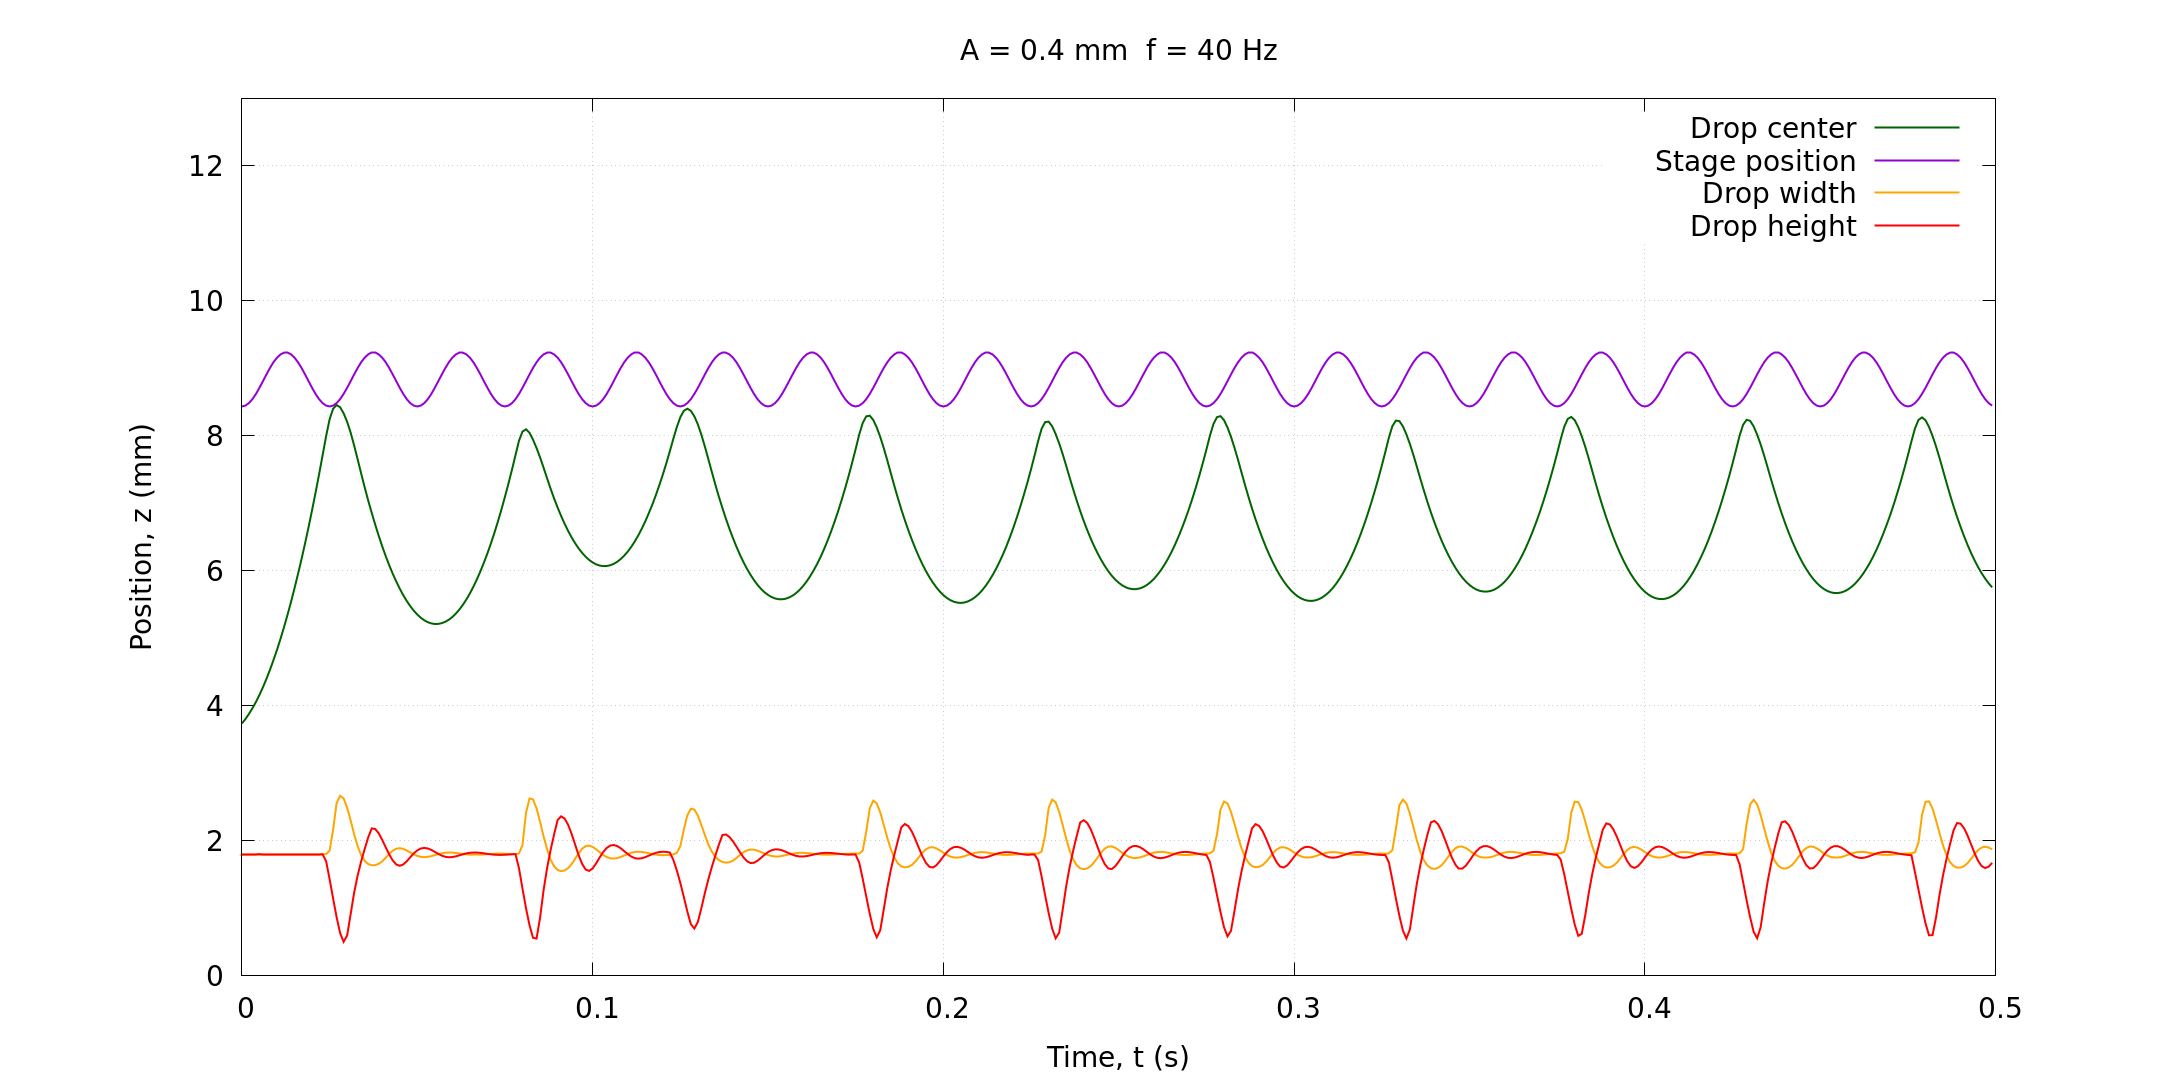

In [ ]:
a1f2 = loadtxt("./positions/POS_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp1.00e-04_freq2.00e+01_momentum0_LEVEL9")
a1f4 = loadtxt("./positions/POS_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp1.00e-04_freq4.00e+01_momentum0_LEVEL9")
a1f6 = loadtxt("./positions/POS_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp1.00e-04_freq6.00e+01_momentum0_LEVEL9")
a2f2 = loadtxt("./positions/POS_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp2.00e-04_freq2.00e+01_momentum0_LEVEL9")
a2f4 = loadtxt("./positions/POS_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp2.00e-04_freq4.00e+01_momentum0_LEVEL9")
a2f6 = loadtxt("./positions/POS_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp2.00e-04_freq6.00e+01_momentum0_LEVEL9")
a3f2 = loadtxt("./positions/POS_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp3.00e-04_freq2.00e+01_momentum0_LEVEL9")
a3f4 = loadtxt("./positions/POS_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp3.00e-04_freq4.00e+01_momentum0_LEVEL9")
a3f6 = loadtxt("./positions/POS_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp3.00e-04_freq6.00e+01_momentum0_LEVEL9")
a4f2 = loadtxt("./positions/POS_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp4.00e-04_freq2.00e+01_momentum0_LEVEL9")
a4f4 = loadtxt("./positions/POS_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp4.00e-04_freq4.00e+01_momentum0_LEVEL9")
a4f6 = loadtxt("./positions/POS_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp4.00e-04_freq6.00e+01_momentum0_LEVEL9")

In [ ]:
v_a1f2 = loadtxt("./velocities/VEL_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp1.00e-04_freq2.00e+01_momentum0_LEVEL9")
v_a1f4 = loadtxt("./velocities/VEL_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp1.00e-04_freq4.00e+01_momentum0_LEVEL9")
v_a1f6 = loadtxt("./velocities/VEL_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp1.00e-04_freq6.00e+01_momentum0_LEVEL9")
v_a2f2 = loadtxt("./velocities/VEL_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp2.00e-04_freq2.00e+01_momentum0_LEVEL9")
v_a2f4 = loadtxt("./velocities/VEL_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp2.00e-04_freq4.00e+01_momentum0_LEVEL9")
v_a2f6 = loadtxt("./velocities/VEL_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp2.00e-04_freq6.00e+01_momentum0_LEVEL9")
v_a3f2 = loadtxt("./velocities/VEL_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp3.00e-04_freq2.00e+01_momentum0_LEVEL9")
v_a3f4 = loadtxt("./velocities/VEL_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp3.00e-04_freq4.00e+01_momentum0_LEVEL9")
v_a3f6 = loadtxt("./velocities/VEL_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp3.00e-04_freq6.00e+01_momentum0_LEVEL9")
v_a4f2 = loadtxt("./velocities/VEL_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp4.00e-04_freq2.00e+01_momentum0_LEVEL9")
v_a4f4 = loadtxt("./velocities/VEL_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp4.00e-04_freq4.00e+01_momentum0_LEVEL9")
v_a4f6 = loadtxt("./velocities/VEL_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp4.00e-04_freq6.00e+01_momentum0_LEVEL9")

In [ ]:
a0f0 = loadtxt("./positions/POS_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp0.00e+00_freq0.00e+00_momentum0_LEVEL11")
v_a0f0 = loadtxt("./velocities/VEL_OIL1_dia1.80e-03_pos5.10e-03_vel6.50e-02_amp0.00e+00_freq0.00e+00_momentum0_LEVEL11")


In [ ]:
l1 = 200
l2 = len(a1f2[:,0])

In [ ]:
_trajectories = [ [a0f0[l1:l2, 2], v_a0f0[l1:l2, 3]] - np.array([1,0]).reshape(-1,1)]
_times = [a0f0[l1:l2,0]]


In [ ]:
tmp = 0
plt.xlabel('$x$')
plt.ylabel('$\\dot{x}$')
for t in _trajectories:
    if tmp == 0:
        plt.plot(t[0,:], t[1,:], '-', c='blue')
        tmp+=1
    else:
        plt.plot(t[0,:], t[1,:], '-', c='red')

In [ ]:
# Order
_polyDeg = 3
# Degrees of freedom
_ndofs = 1

_X, _y  = shift_or_differentiate(_trajectories, _times, 'flow') 

# constLHS = [[0, 1]]
# constRHS = [[0, 0]]
# cons = [constLHS, constRHS]

_mdl = ridge.get_fit_ridge(_X, _y, poly_degree = _polyDeg) #, constraints = cons)

_linearPart = _mdl.map_info['coefficients'][:,:2]

_nf, _n_unknowns_dynamics, _n_unknowns_transformation, _objectiv \
    = normalform.create_normalform_transform_objective(_times, _trajectories, _linearPart, degree = _polyDeg)

_initial_guess = normalform.create_normalform_initial_guess(_mdl, _nf)

np.random.seed(3)
_res = least_squares(_objectiv, _initial_guess, jac='2-point', method='lm')

_d = normalform.unpack_optimized_coeffs(_res.x, _ndofs, _nf, _n_unknowns_dynamics, _n_unknowns_transformation)

_trf, _dyn = normalform.wrap_optimized_coefficients(_ndofs, _nf, _polyDeg, _d )

In [ ]:
_dyn

In [ ]:
_time_pred = _times[0]

In [ ]:
clit=1
for t in _trajectories:
    if clit==1:
        transformed = _trf.inverse_transform(t)
        plt.plot(np.real(transformed[0,:]), np.imag(transformed[0,:]), '-', c='blue', label = 'Training')
        ic = transformed[:,0]
        
        pred = solve_ivp(_dyn['vectorfield'], [_time_pred[0], _time_pred[-1]], ic, t_eval=_time_pred, method = 'DOP853')
        plt.plot(np.real(pred.y[0,:]), np.imag(pred.y[0,:]), '--', c='blue', label = 'Prediction')
        clit+=1
    elif clit==2:
        transformed = _trf.inverse_transform(t)
        # plt.plot(np.real(transformed[0,:]), np.imag(transformed[0,:]), '-', c='red', label = 'Training')
        ic = transformed[:,0]
    
        pred = solve_ivp(_dyn['vectorfield'], [_time_pred[0], _time_pred[-1]], ic, t_eval=_time_pred, method = 'DOP853')
        # plt.plot(np.real(pred.y[0,:]), np.imag(pred.y[0,:]), '--', c='red', label = 'Prediction')
        clit+=1
plt.xlabel('$\\eta_1$')
plt.ylabel('$\\eta_2$')
plt.legend()

In [ ]:
f,ax = plt.subplots(2,4,figsize = (13, 8))
orders = [3, 5, 7, 9]
n_orders = len(orders)
for i in range(n_orders):
    order = orders[i]
    _mdl = ridge.get_fit_ridge(_X, _y, poly_degree = order) # pre-fit with regular ridge regression
    _linearPart = _mdl.map_info['coefficients'][:,:2]

    _nf, _n_unknowns_dynamics, _n_unknowns_transformation, _objectiv = normalform.create_normalform_transform_objective(_times, _trajectories, _linearPart, degree = order)
    _initial_guess = normalform.create_normalform_initial_guess(_mdl, _nf)
    _res = least_squares(_objectiv, _initial_guess, jac='2-point', method='lm')
    print('Order: %s, Residual: %s \n' %(order, _res.cost))
    _d = normalform.unpack_optimized_coeffs(_res.x, _ndofs, _nf, _n_unknowns_dynamics, _n_unknowns_transformation)
    _trf, _dyn = normalform.wrap_optimized_coefficients(_ndofs, _nf, order, _d )
    ax[0,i].set_xlabel('$\\eta_1$')
    ax[0,i].set_title('Order: %s' %order)
    for t in _trajectories:
        _transformed = _trf.inverse_transform(t)
        ax[0,i].plot(np.real(_transformed[0,:]), np.imag(_transformed[0,:]), '-', c='black', label = 'Training')
        _ic = _transformed[:,0]
        _pred = solve_ivp(dyn['vectorfield'], [_time_pred[0], _time_pred[-1]], _ic, t_eval=_time_pred, method = 'DOP853')
        ax[0,i].plot(np.real(_pred.y[0,:]), np.imag(_pred.y[0,:]), '--', c='Crimson', label = 'Prediction')
        ## we also compute the error along trajectories
        _tonorm = np.max(np.abs(_transformed[:,0]))
        _error = np.abs(_pred.y[0,:] - _transformed[0,:])/_tonorm
        ax[1,i].semilogy(_pred.t, _error*100, '-', c='grey', label ='Relative error')
            
    ax[1,i].grid()  
    ax[1,i].set_xlabel('Time')
ax[0,0].set_ylabel('$\\eta_2$')
ax[1,0].set_ylabel('Relative error [%]')